In [115]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import os
import quandl
from datetime import datetime
import backtrader as bt
import backtrader.feeds as btfeeds
import backtrader.analyzers as btanalyzers
import matplotlib.pyplot as plt
import pandas_datareader as pdr
from graham import *

quandl.ApiConfig.api_key = os.getenv('QUANDL_APY_KEY')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
def get_trading_data(ticker, start_date, end_date, source='yahoo'):
    if source == 'yahoo':
        result = pdr.get_data_yahoo(symbols=ticker, start=start_date, end=end_date)
        result = result[['Open', 'High', 'Low', 'Adj Close', 'Volume']][:-1]
        result.columns = ['open', 'high', 'low', 'close', 'volume']
        result.index.names = ['date']
    elif source == 'sharadar':
        columns = ['date', 'open', 'high', 'low', 'close', 'volume']
        result = quandl.get_table('SHARADAR/SEP', ticker=ticker, qopts={"columns":columns}, 
                              date={'gte': start_date, 'lte': end_date})
        result.set_index('date', inplace=True)
        result.sort_index(inplace=True)
    else:
        result = pd.DataFrame()

    df_pe = quandl.get_table('SHARADAR/DAILY', ticker=ticker, qopts={"columns":["date", "pe"]}, 
                              date={'gte': start_date, 'lte': end_date})
    df_pe.set_index('date', inplace=True)
    df_pe.sort_index(inplace=True)

    result = pd.concat([result, df_pe], axis=1)
    return result

In [18]:
start_date = datetime(2008, 12, 31)
end_date = datetime(2019, 1, 1)

df1 = get_trading_data('NKE', start_date, end_date)
df2 = get_trading_data('BAX', start_date, end_date)

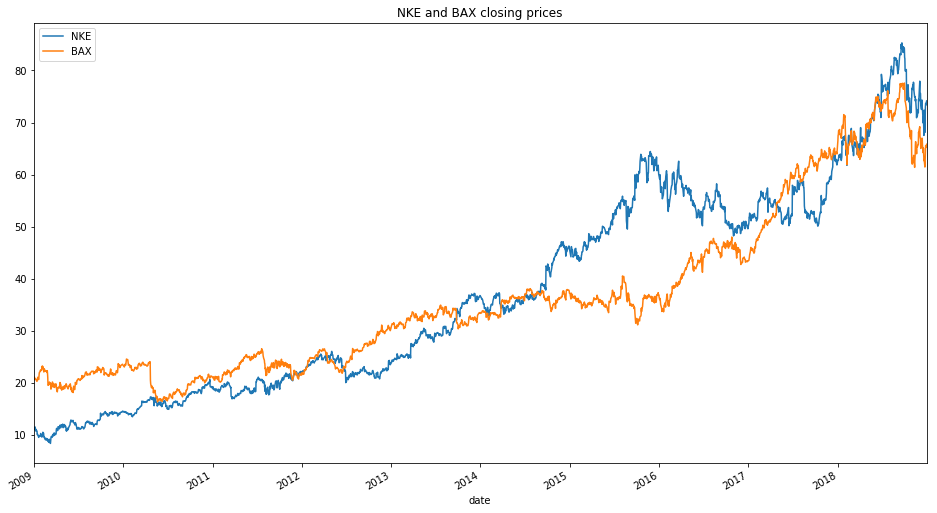

In [23]:
pd.concat([df1[['close']].rename(columns={'close': 'NKE'}), 
           df2[['close']].rename(columns={'close': 'BAX'})], 
          axis=1).plot(title=f"NKE and BAX closing prices", figsize=(16, 9))

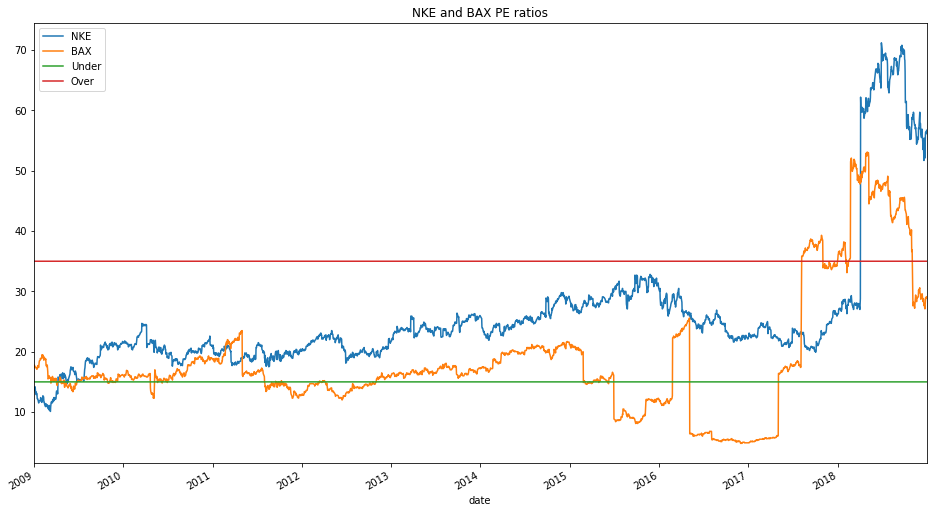

In [277]:
df_temp = pd.concat([df1[['pe']].rename(columns={'pe': 'NKE'}), 
                     df2[['pe']].rename(columns={'pe': 'BAX'})], 
                    axis=1)
df_temp['Under'] = 15
df_temp['Over'] = 35
df_temp.plot(title=f"NKE and BAX PE ratios", figsize=(16, 9))

## Adding data to Backtrader

In [78]:
class PandasData2(btfeeds.PandasData):
    lines = ('pe',)
    params = (('pe', -1), ('name', 'teste'), )
    
data1 = PandasData2(dataname=df1, name='NKE')
data2 = PandasData2(dataname=df2, name='BAX')

## Defining the strategy

In [272]:
class TestStrategy(bt.Strategy):
    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        self.cash = 0
        self.order = None
        
    def notify_cashvalue(self, cash, value):
        self.cash = cash
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY {order.data.params.name} EXECUTED, Price: {order.executed.price:.2f}, Amount: {order.executed.size:.2f}')
            elif order.issell():
                self.log(f'SELL {order.data.params.name} EXECUTED, Price: {order.executed.price:.2f}, Amount: {order.executed.size:.2f}')

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None
        

    def next(self):
        
        # Simply log the closing price of the series from the reference
        #self.log(f'Close, {ticker2}: Price: {self.dataclose2[0]:.2f} / PE: {self.pe2[0]:.2f}')
        
        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return
        
        for line in self.datas:
            if self.getposition(line).size == 0:
                if line.pe[0] < 15:
                    self.log(f'Buy opportunity for {line.params.name}, Price: {line.close[0]:.2f}, PE: {line.pe[0]}')
                    self.order = self.buy(data=line, size=int(35000.0/line.close[0]))
            else:
                if line.pe[0] > 35:
                    self.log(f'Sell opportunity for {line.params.name}, Price: {line.close[0]:.2f}, PE: {line.pe[0]}')
                    self.order = self.sell(data=line, size=self.getposition(line).size)


In [273]:
cerebro = bt.Cerebro()
cerebro.addstrategy(TestStrategy)
cerebro.adddata(data1)
cerebro.adddata(data2)
cerebro.broker.setcash(100000.0)

cerebro.addanalyzer(btanalyzers.AnnualReturn, _name='ar')
cerebro.addanalyzer(btanalyzers.TimeReturn, _name='tr')

cerebro.addobserver(bt.observers.Value)

initial_value = cerebro.broker.getvalue()
print('Starting Portfolio Value: %.2f' % initial_value)

thestrats = cerebro.run()
thestrat = thestrats[0]

final_value = cerebro.broker.getvalue()
print('Final Portfolio Value: %.2f' % final_value)

Starting Portfolio Value: 100000.00
2008-12-31, Buy opportunity for NKE, Price: 11.03, PE: 13.6
2009-01-02, BUY NKE EXECUTED, Price: 12.74, Amount: 3172.00
2009-03-11, Buy opportunity for BAX, Price: 18.82, PE: 14.8
2009-03-12, BUY BAX EXECUTED, Price: 26.38, Amount: 1860.00
2017-08-07, Sell opportunity for BAX, Price: 58.81, PE: 35.8
2017-08-08, SELL BAX EXECUTED, Price: 59.66, Amount: -1860.00
2018-04-05, Sell opportunity for NKE, Price: 69.02, PE: 62.2
2018-04-06, SELL NKE EXECUTED, Price: 68.51, Amount: -3172.00
Final Portfolio Value: 338806.71


In [274]:
od = thestrat.analyzers.ar.get_analysis()
df = pd.DataFrame.from_dict(od, orient='index', columns=['Annual Return'])
df

,Annual Return
2008,0.000000
2009,0.002169
2010,0.101936
2011,0.086879
2012,0.189189
2013,0.327150
2014,0.187107
2015,0.200126
2016,-0.078695
2017,0.277694


In [275]:
avg_annual_return = (final_value / initial_value) ** (1 / (df1.ix[-1].name.year - df1.ix[0].name.year)) - 1
print(f'Average annual return: {avg_annual_return:.1%}')

Average annual return: 13.0%


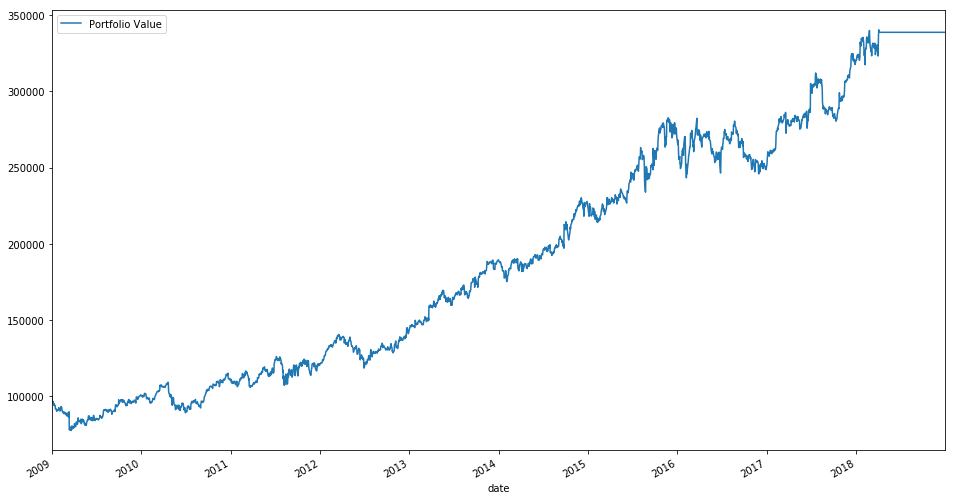

In [276]:
x = thestrat.observers[0].value.plot()
df_pvalue = pd.DataFrame(x, index=df1.index, columns=['Portfolio Value'])
df_pvalue.plot(figsize=(16, 9))